# Тестовое задание.

**Бизнес задача:** <br> 
Во время пиковых нагрузок переодически в местах заказа такси не хватает машин. 
Тем самым компания теряет прибыль.<br>
Нужно понимать в каких местах, какое количество машин должно быть, чтобы промотивировать таксистов приехать и ожидать клиентов в этих областях.

**Техническая задача:**<br>
Даны данные о поездках такси за 6 месяцев 2015 года
(время, долгота и широта начала поездки) - фаил yellow_tripdata_2015.zip.

*Задача:*<br>
1 Найти и выделить область, откуда совершается наибольшее кол-во поездок. Область можно определять любой формы и размера. Визуализация на карте приветствуется (хитмап + выделенная область).<br>
2 Для области из пункта 1 построить модель по предсказанию кол-ва поездок из этой области на час вперед. Baseline - в качестве предсказания использовать предыдущее значение. Желательно побить baseline своей моделью. Метрику выбираете сами.<br> 

In [1]:
#Отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Подключаем графические модули:
# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


#Подключаем модули для работы с ML
import numpy as np
import pandas as pd

#Для отрисовки дерева
from sklearn.tree import export_graphviz
from IPython.display import Image

#Для моделей
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.learning_curve import learning_curve

from scipy import stats
from scipy.sparse import csr_matrix, coo_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer

/home/edvard/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/edvard/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Часть 1

Найти и выделить область, откуда совершается наибольшее кол-во поездок. Область можно определять любой формы и размера. Визуализация на карте приветствуется (хитмап + выделенная область).


In [2]:
%%time
#Считываем данные и отобразим первые столбцы
data = pd.read_csv('yellow_tripdata_2015.csv', index_col='Unnamed: 0', nrows=10000)
data.head(5)

CPU times: user 41.2 ms, sys: 16.1 ms, total: 57.4 ms
Wall time: 67.2 ms


In [3]:
#Посмотрим справочную информацию по данным
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
tpep_pickup_datetime    10000 non-null object
pickup_longitude        10000 non-null float64
pickup_latitude         10000 non-null float64
dtypes: float64(2), object(1)
memory usage: 312.5+ KB


In [4]:
%%time
#Проверим есть ли пропуски. 
#Код возвращает те строки, где есть True (в нашем случаи это как раз NaN)
#Если код вернет пустой DataFrame значит пропусков нет.
data[data.isnull().any(axis=1)]

CPU times: user 11.9 ms, sys: 587 µs, total: 12.5 ms
Wall time: 13.2 ms


,tpep_pickup_datetime,pickup_longitude,pickup_latitude


**Вывод:** Пропусков в данных нет, тк получили пустой DataFrame

In [5]:
#Выведем данные. Можно заметить, что у части поездок стоят нулевые долгота и широта.
data['pickup_longitude'].value_counts().head(10)
data['pickup_latitude'].value_counts().head(10)

0.000000     142
40.773811      6
40.768860      6
40.740528      5
40.762772      5
40.769024      5
40.742031      5
40.760368      5
40.768505      5
40.756191      5
Name: pickup_latitude, dtype: int64

In [6]:
%%time
#Очистим эти данные, у которых нет longitude или latitude
data = data[(data['pickup_latitude']!=0.000000) & (data['pickup_longitude']!=0.000000)].round(2)

CPU times: user 18 ms, sys: 308 µs, total: 18.3 ms
Wall time: 18.1 ms


**Оступление**:<br>
Вверху можно заметить, что мы огруглили *долготу и широту*

Длина одного градуса широты на Земле составляет приблизительно 111 километров.<br>
Одна минута широты составляет приблизительно 1.85 километр.<br> 
Одна секунда широты составляет приблизительно 0.03 километр, или примерно 30 метров.<br>

Поэтому округлив наши данные до минут, мы сможем найти место, откуда совершается бОльшая часть поездок<br> 
Далее можно уже более детально, обращаясь к секундам, проанализировать выбранную область, если это потребуется.

In [7]:
%%time
#Подготовим данные для визуализации в heatmap
#Для этого нам нужно создать сводную таблицу и заполним пропуски нулями.
heatmap_table = data.pivot_table(index='pickup_longitude',columns='pickup_latitude',values='tpep_pickup_datetime', aggfunc='count').fillna(0)

CPU times: user 32.3 ms, sys: 0 ns, total: 32.3 ms
Wall time: 34.2 ms


CPU times: user 1.53 s, sys: 93.8 ms, total: 1.62 s
Wall time: 1.71 s


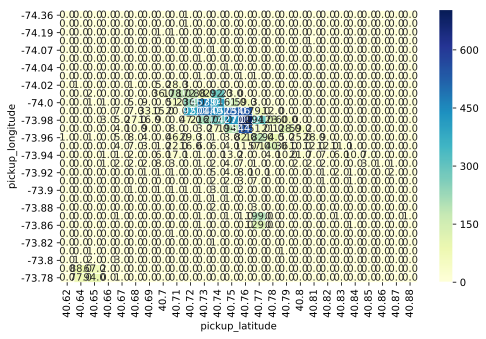

In [8]:
%%time
#Cтроим карту heatmap
sns.heatmap(heatmap_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5);

# Часть 2

Для области из пункта 1 построить модель по предсказанию кол-ва поездок из этой области на час вперед. Baseline - в качестве предсказания использовать предыдущее значение. Желательно побить baseline своей моделью. Метрику выбираете сами.

**План решения:**<br>
1) Формирование таблицы: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -выделяем нужную область<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -предобрабатываем данные(дату)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -добавляем столбец "кол-во поездок" в этой области.<br>
2) Построение модели: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -первичный анализ целевой переменной<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -выбор метрики и обосновывание ее.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -формирование baseline модели<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -выбор модели, кросс-валидация и настройка гиперпараметров<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -прогноз для отложенной выборки<br>
3) Результаты работы <br>
4) Как можно улучшить модель <br>
5) Интересные факты

# Формирование таблицы

In [9]:
%%time
#Считываем данные и отобразим первые столбцы
data = pd.read_csv('yellow_tripdata_2015.csv', index_col='Unnamed: 0', nrows=1000000)

#Очистим эти данные, у которых нет (longitude и latitude)
data = data[(data['pickup_latitude']!=0.000000) & (data['pickup_longitude']!=0.000000)].round(2)

CPU times: user 2.24 s, sys: 304 ms, total: 2.54 s
Wall time: 2.55 s


### Выделяем нужную область

In [10]:
# Наиболее загруженные координаты из предыдущего пункта Долгота(-73.97 до -74.01) и Широта(40.72 до 40.77)
data = data[(data['pickup_longitude']>-74.01) & (data['pickup_longitude']<-73.97)&
                    (data['pickup_latitude'] > 40.72) & (data['pickup_latitude'] <40.77)]

### Предобрабатываем данные(дату)

In [11]:
%%time
#Преобразование даты в datetime
data['pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

CPU times: user 465 ms, sys: 11 ms, total: 476 ms
Wall time: 472 ms


In [12]:
%%time
#Выделение месяца, дня, часа
#Год не выделяем, тк у нас только один 2015г, он не будет нести для нашей модели информативность
data['month'] =   data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour

CPU times: user 138 ms, sys: 215 µs, total: 139 ms
Wall time: 138 ms


In [13]:
#Удаляем ненужные колонки
data.drop(['tpep_pickup_datetime', 'pickup_datetime'], axis=1, inplace=True) 

### Добавляем столбец "кол-во поездок" в этой области

In [14]:
%%time
#Группируем данные по дате и координатам,  так же добавляем столбец с кол-вом поездок 
data = data.groupby(['month','day','hour','pickup_longitude', 'pickup_latitude']).size().reset_index(name="trips")

CPU times: user 131 ms, sys: 3.89 ms, total: 135 ms
Wall time: 133 ms


In [15]:
data.head()

,month,day,hour,pickup_longitude,pickup_latitude,trips
0,7,1,0,-74.00,40.73,621
1,7,1,0,-74.00,40.74,536
2,7,1,0,-74.00,40.75,213
3,7,1,0,-74.00,40.76,71
4,7,1,0,-73.99,40.73,713


# Построение модели

### Первичный анализ целевой переменной

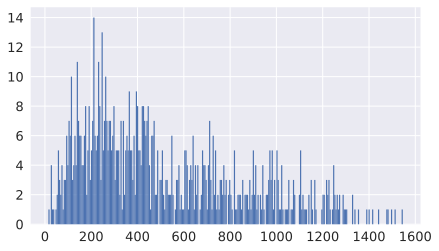

In [16]:
#Посмотрим на распределение целевого признака
sns.set(font_scale=1.3)
plt.figure(figsize=(7,4))
data['trips'].hist(bins=300);

Распределение перекошено несильно, если бы перекошенность была намного сильнее, тогда бы мы использовали логарифмирование

In [17]:
# Посмотрим, что говорят статистические тесты.
from scipy import stats
print(stats.normaltest(data['trips']))
print('skew=',stats.skew(data['trips']))
print(stats.skewtest(data['trips']))


NormaltestResult(statistic=72.07265797952188, pvalue=2.2367691884855656e-16)
skew= 0.783715897495872
SkewtestResult(statistic=8.272024407422164, pvalue=1.3170333235150035e-16)


***Вывод***: Благодаря статистическим тестам, ну это можно увидеть на графике, наши данные не распределены по нормальному распределению.  Также мы видим небольшую скошенность распределения. Это не очень хорошо для многих методов машинного обучения.

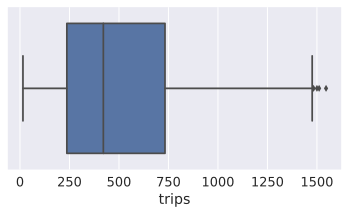

In [18]:
plt.figure(figsize=(6,3))
sns.boxplot( x='trips', data=data, orient="h");

**Вывод:** Видим, что в данных есть небольшие выборсы.
Скорее всего эти выборы как раз указывают на самый пик активности, либо какие-то праздники, когда в обычный день наблюдается анамальное число заказов

### Выбор метрики и обоснование ее

Так как мы решаем задачу регрессии, то можно использовать метрику MSE. Впринципе, можно было бы использовать и R2 метрику (коэффициент детерминации), но, вооружившись baseline в виде начального приближения средним, будем использовать MSE. 

###  Формирование baseline модели

Сформируем baseline, как среднюю оценку на train

In [217]:
df = data.copy(deep=True)

In [218]:
y = df['trips']
X = df.drop(['trips'], axis=1) 

In [278]:
#Разбиение выборки на train и test, первый 'baseline'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False,random_state=42)

In [279]:
#Среднее значение оценки на трейне
y_mean=y_train.mean()
y_mean_for_test=[float(y_mean) for x in range(len(y_test))]
y_mean_for_train=[float(y_mean) for x in range(len(y_train))]

In [280]:
#Результаты приближения средним на трейне
print(mean_squared_error(y_train,y_mean_for_train))

134610.77659952096


In [281]:
#Результаты приближения средним на тесте.
#Получили baseline
baseline_mean=mean_squared_error(y_test,y_mean_for_test)
print(mean_squared_error(y_test,y_mean_for_test))

84495.50268688203


### Выбор модели, кросс-валидация и настройка гиперпараметров

Для данной задачи случайный лес, может очень хорошо подойти, так как в задаче не очень большое количество признаков.<br> Для линейных моделей лучше был бы sparse формат: более разряжанный формат признаков.   
Впрочем, ничто не мешает опробовать и другие регрессоры, что мы и сделаем далее.

Испробуем несколько моделей, после выберем наилучшую.


In [282]:
#Приступим к выбору модели
#Список регрессоров
regressors = [LinearRegression(),
               RandomForestRegressor(random_state=42), 
               LinearSVR(random_state=42)]
regressor_name = ['LinearRegression',
                    'RandomForestRegressor', 
                    'LinearSVR']

In [283]:
#Параметры к регрессорам
scores = []
fits = []
linear_params = {'normalize': (True, False)}
forest_params = {'n_estimators': [100], 
                 'max_depth': list(range(3, 12, 4)), 
                 #'min_samples_leaf': list(range(10, 31, 10))
                }

svm_params = {'loss' : ('epsilon_insensitive', 'squared_epsilon_insensitive'), 'C': (0.1,0.25,0.5, 1, 2)}
params = [linear_params, forest_params, svm_params]

In [284]:
#Так как у нас временной ряд, нужно использовать правильное разбиение для кросс-валидации
tscv = TimeSeriesSplit(n_splits=3)

In [285]:
%%time
#Перебираем параметры регрессоров в поисках лучшего (на 3 фолдах)
np.random.seed(42)
for i, each_regressor in enumerate(regressors):
    reg = each_regressor
    reg_params = params[i]
    grid = GridSearchCV(reg, reg_params, 
                        cv=tscv,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    reg_best_score = grid.best_score_
    scores.append(reg_best_score)
    print(regressor_name[i], -reg_best_score, "\n", grid.best_params_, "\n")

LinearRegression 171720.58399931653 
 {'normalize': False} 

RandomForestRegressor 24067.004021392004 
 {'max_depth': 11, 'n_estimators': 100} 

LinearSVR 115741.13439547084 
 {'C': 2, 'loss': 'epsilon_insensitive'} 

CPU times: user 1.99 s, sys: 399 ms, total: 2.39 s
Wall time: 4.44 s


**Вывод:** Из моделей лучше всего сработал RandomForest.  Лучшие его параметры можно посмотреть выше.

### Прогноз для отложенной выборке

In [287]:
# Обучим нашу модель
rfr = RandomForestRegressor(max_depth=11,n_estimators=100 ,random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [288]:
predict = rfr.predict(X_test)

In [289]:
mean_squared_error(y_test, predict)

65856.68368754513

In [291]:
print('our_model:',mean_squared_error(y_test, predict),'vs baseline:',baseline_mean)

our_model: 65856.68368754513 vs baseline: 84495.50268688203


 ### Вывод: ### 
 Мы побили baseline модели, единственно надо обратить внимание на кроссвалидацию, тк есть расхождения в цифрах с изначальной выборкой.

# Результаты работы

**Техническая задача:**<br>
Было спргнозировано количество поездок по наиболее загруженным областям.
Также хочется заметить, что модель существенно обогнала заранее взятый наш baseline в виде моделинрования
средней загрузки по данным областям.

**Бизнес задача:**<br>
Благодаря решеннию технической задачи, теперь ясно какое количество машин должно находиться в области пиковых нагрузок в нужные часы. 
Далее возможно реализовать повышенные коэффициенты для водителей в этих областях в нужные часы.
Это промотивирует водителей приезжать в нужные районы, тем самым компания не будет терять прибыль,
тк нужное количество машин будет на месте.

# Что можно еще сделать

**1 Модель ARIMA / Facebook Prophet ** <br>
В данной работе совсем не была освещена полноценная работа с временными рядами(стационарность/нестационарность, применение ARIMA, Prophet моделей и тд...)
Делалось это намеренно, тк применение и настройка параметров этих моделей занимает много времени.
Много времени уходит на подготовку данных, настройку, а также требует частого переобучения на новых данных для продакшн-решения. Поэтому зачастую проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или решаюший лес.
Поэтому, если требуется бОльшая точность стоит попробовать настроить и модели SARIMA / Prophet.<br>
Возможно они дадут более лучший результат.

**2 Blending ** <br>
Не использовался метод блендинга моделей. Если просто усредний показатели всех моделей, то метрику можно улучшить.

**3 Feature Engineering** <br>
Провести более подробный Feature Engineering. Можно добавить из открытй источников: название районов, численность проживаемого населения в них, также выделить праздничные дни...Применить модель TF-IDF на днях. Использовать библиотеку *Tsfresh* для выделения бОльшего числа признаков и посмотреть улучшаться ли показатели нашей модели.

# PS Интересные факты
Посмотрев на долготу и широту на карте в точках датасета, оказалось, что это районы США. <br>
Хотя до этого думал, что это координаты районов Москвы.